In [2]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')
# jax.config.update("jax_debug_nans", True)
# jax.config.update("jax_disable_jit", True)
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import numpy as np
import jax.numpy as jnp
import os
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import time as t
#%matplotlib widget

from classy import Class # import classy module


## these are the main packages for background evolution and perturbation evolution
from discoeb.background import evolve_background
from discoeb.perturbations import evolve_perturbations, determine_starting_time

cpu


In [3]:
# ## Set the Cosmological ParametNeutrino Mass from Voronoi Void-Halos?ers

## Cosmological Parameters
Tcmb    = 2.7255
YHe     = 0.248
Omegam  = 0.3099
Omegab  = 0.0488911
Omegac  = Omegam - Omegab
w_DE_0  = -0.99
w_DE_a  = 0.0
cs2_DE  = 1.0
# Initialize neutrinos.
num_massive_neutrinos = 1
mnu     = 0.06  #eV
Tnu     = (4/11)**(1/3) #0.71611 # Tncdm of CLASS
Neff    = 3.046 # -1 if massive neutrino present
N_nu_mass = 1
N_nu_rel = Neff - N_nu_mass * (Tnu/((4/11)**(1/3)))**4
h       = 0.67742
A_s     = 2.1064e-09
n_s     = 0.96822
k_p     = 0.05

# modes to sample
nmodes = 2**4 #512
kmin = 1e-4
kmax = 1e+1
aexp = 1

# insert parameters into a dictionary
param = {}
param['Omegam']  = Omegam
param['Omegab']  = Omegab
# param['OmegaDE'] = OmegaDE
param['w_DE_0']  = w_DE_0
param['w_DE_a']  = w_DE_a
param['cs2_DE']  = cs2_DE
param['Omegak']  = 0.0
param['A_s']     = A_s
param['n_s']     = n_s
param['H0']      = 100*h
param['Tcmb']    = Tcmb
param['YHe']     = YHe
param['Neff']    = Neff
param['Nmnu']    = num_massive_neutrinos
param['mnu']     = mnu
param['k_p']     = k_p

In [4]:
print("N_modes -> ", nmodes)
t_bg1 = t.time()
param  = evolve_background(param=param, thermo_module='RECFAST')#, class_thermo=thermo)
t_bg2 = t.time()
print('Background computation time -> ', t_bg2 - t_bg1)
# print(param['Omegamnu'], ' ', mnu / 93.14 / h ** 2)

# compute perturbation evolution
# aexp_out = jnp.array([aexp])
aexp_out = jnp.array(np.linspace(0.1,aexp,10))
rtol = 1e-4
atol = 1e-4
t_pt1 = t.time()
# y, kmodes = evolve_perturbations( param=param, kmin=kmin, kmax=kmax, num_k=nmodes, aexp_out=aexp_out, 
#                                   rtol=rtol, atol=rtol, max_steps = int(2**14) )
y, kmodes = evolve_perturbations( param=param, kmin=kmin, kmax=kmax, num_k=nmodes, aexp_out=aexp_out, 
                                  # pcoeff = 0.0, icoeff = 1.0, dcoeff = 0.0, factormax = 10.0, factormin = 0.5,
                                  # pcoeff = 0.25, icoeff = 0.6, factormax = 20.0, factormin = 0.3, 
                                  # lmaxg = 25, lmaxgp = 25, lmaxr = 25, lmaxnu = 25, nqmax = 25,
                                  lmaxg = 11, lmaxgp = 11, lmaxr = 11, lmaxnu = 11, nqmax = 5,
                                  max_steps=8192,
                                  rtol=rtol, atol=atol )
t_pt2 = t.time()
print('Perturbations computation time -> ', t_pt2 - t_pt1)

N_modes ->  16
Background computation time ->  8.883389949798584
Perturbations computation time ->  31.129898071289062


# Anisotropic stress equation test

Equation for $A = h +6\eta$ (Eq. 21d MB95)
$$\ddot{A} + 2\mathcal{H}\dot{A} -2k^2\eta = -24\pi G a^2(\overline{\rho} + \overline{p})\sigma$$

Splited as the system $B = \dot{A}$, $\dot{B} = ...$

Comparision with $B$ constructed from the solutions of $\dot{h}$ and $\dot{\eta}$.

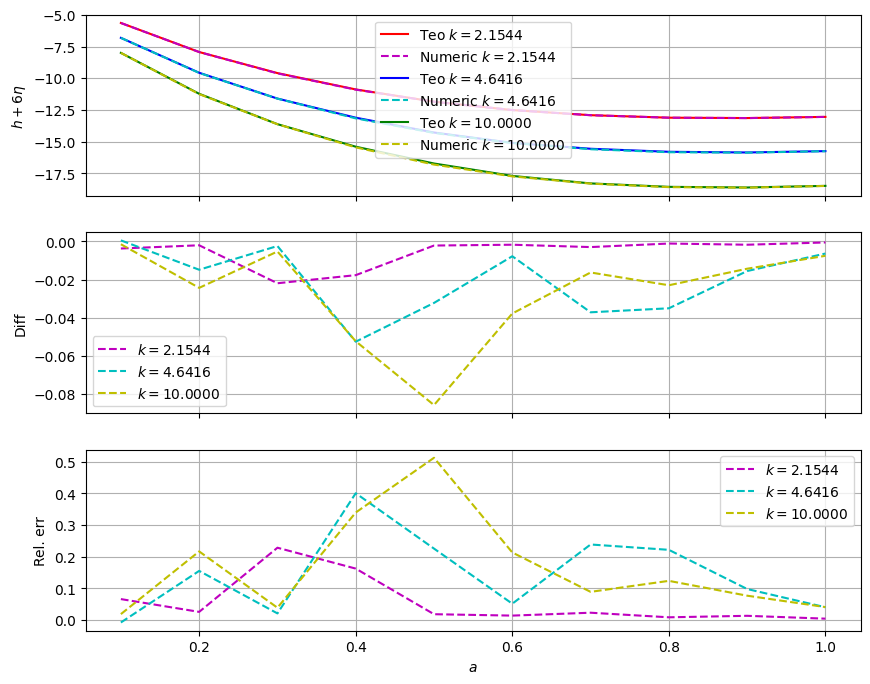

In [5]:
B = y[:,:,21] # Numerical Solution is in conformal scale factor 

hprime = y[:,:,2]
etaprime = y[:,:,1]
B_teo = hprime + 6*etaprime

k_indices = [-3,-2,-1]
clrs_teo = ['r', 'b', 'g']
clrs_num = ['m--', 'c--', 'y--']

fig, ax = plt.subplots(3,figsize=(10, 8),sharex = True)

for it in range(len(k_indices)):
    indx = k_indices[it]
    ax[0].plot(aexp_out,B_teo[indx,:],clrs_teo[it] ,label = 'Teo $k= %.4f$' % kmodes[indx])
    ax[0].plot(aexp_out,B[indx,:],clrs_num[it], label = 'Numeric $k= %.4f$' % kmodes[indx])

    ax[1].plot(aexp_out, (B[indx,:] - B_teo[indx,:]), clrs_num[it], label='$k= %.4f$' % kmodes[indx])
    
    ax[2].plot(aexp_out, (B[indx,:] - B_teo[indx,:])/B_teo[indx,:]*100, clrs_num[it], label='$k= %.4f$' % kmodes[indx])

ax[0].grid()
ax[0].legend()
ax[0].set_ylabel("$h + 6\\eta$")

ax[1].grid()
ax[1].legend()
ax[1].set_ylabel("Diff")

ax[2].grid()
ax[2].legend()
ax[2].set_ylabel("Rel. err")

ax[2].set_xlabel("$a$")
plt.show()

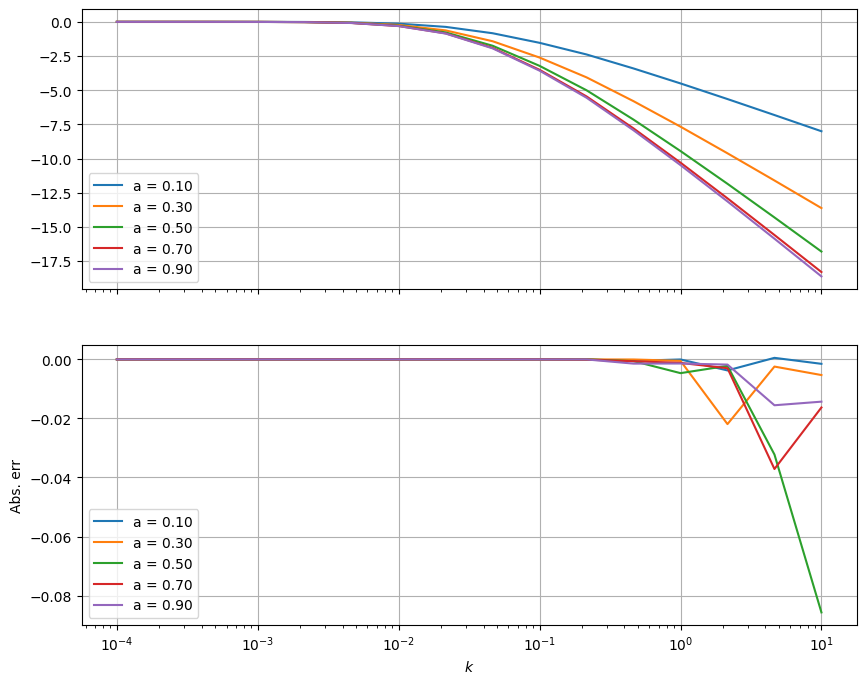

In [6]:
# for i in range(0,B.shape[1],3):
# # rhonu = jnp.exp(param['logrhonu_of_loga_spline'].evaluate(jnp.log(a)))
#     plt.plot(kmodes,B[:,i], label = 'a = %.2f'%aexp_out[i])
#     plt.plot(kmodes,B_teo[:,i], label = 'a = %.2f'%aexp_out[i])(1)*
# plt.legend()
# # plt.xlim(0,0.1)
# plt.grid()
# plt.show()

fig, ax = plt.subplots(2,figsize=(10, 8),sharex = True)

for i in range(0,B.shape[1],2):
    ax[0].semilogx(kmodes,B[:,i] ,label = 'a = %.2f'%aexp_out[i])
    # ax[0].plot(kmodes,B_teo[:,i], label = 'Teo a = %.2f'%aexp_out[i])
    
    ax[1].semilogx(kmodes,(B[:,i] - B_teo[:,i]), label='a = %.2f'%aexp_out[i])

ax[0].grid()
ax[0].legend()

ax[1].grid()
ax[1].legend()
ax[1].set_ylabel("Abs. err")

ax[1].set_xlabel("$k$")

plt.show()


# Potentials comparisions
Comparision on Newtonian potential:   
$\Phi^N = -\frac{1}{k^2}4 \pi G a^2 \overline{\rho}(\delta_m + \frac{1}{2}h) = -\frac{1}{k^2}4 \pi G a^2 \overline{\rho}(\delta_c + \delta_b + (\frac{A}{2} - 3\eta))$,

and Bardeen potential (Eq 18b MB95):   
$\Phi^B = \eta -\frac{1}{2k^2}\mathcal{H}\dot{A}$.

Comparision test:  
$h = \frac{1}{6}(A-\eta) =  -\frac{k^2(\Phi^B - \Phi^N)}{2\pi G\rho_m}$

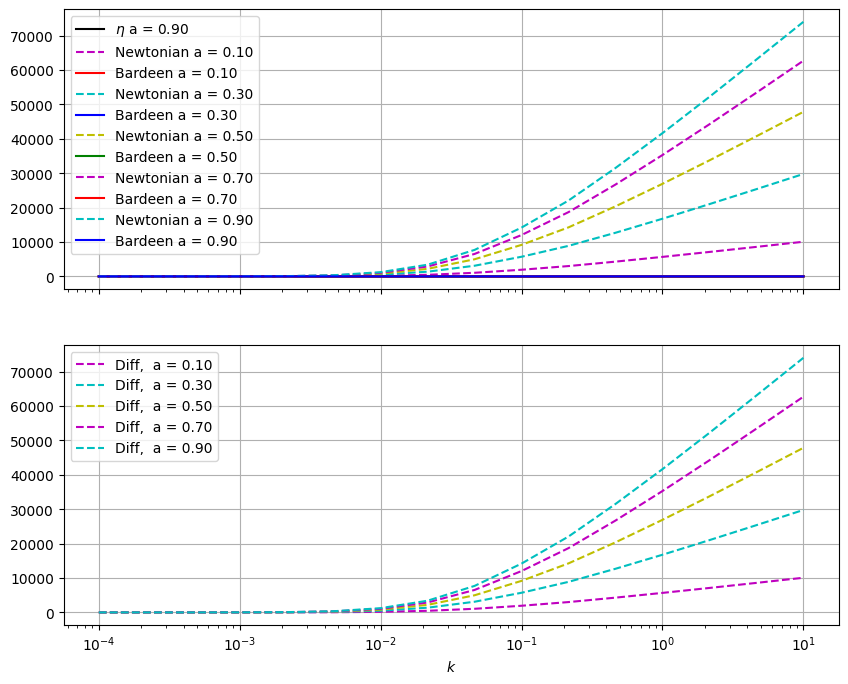

In [6]:
eta = y[:,:,0]
A   = y[:,:,20]
PhiN, PhiB = y[:,:,22], y[:,:,23]
a_index = np.arange(0,PhiN.shape[1], 2)

fig, ax = plt.subplots(2,figsize=(10, 8),sharex = True)
ax[0].semilogx(kmodes,eta[:,a_index[-1]], 'k' ,label = '$\\eta$ a = %.2f'%aexp_out[a_index[-1]])
for it in range(len(a_index)):
    ax[0].semilogx(kmodes,PhiN[:,a_index[it]], clrs_num[it%3] ,label = 'Newtonian a = %.2f'%aexp_out[a_index[it]])
    ax[0].semilogx(kmodes,PhiB[:,a_index[it]], clrs_teo[it%3], label = 'Bardeen a = %.2f'%aexp_out[a_index[it]])
    
    ax[1].semilogx(kmodes,PhiN[:,a_index[it]] - PhiB[:,a_index[it]], clrs_num[it%3], label='Diff,  a = %.2f'%aexp_out[a_index[it]])

ax[0].grid()
ax[0].legend()

ax[1].grid()
ax[1].legend()

ax[1].set_xlabel("$k$")

plt.show()

Comparision test:  
$h = A-6\eta =  -\frac{k^2(\Phi^B - \Phi^N)}{2\pi G a^2\rho_m}$

In [7]:
h_test = (A-6*eta)

EightPiG = 3.33795017e-11
h_phis = np.zeros_like(PhiB)
for it, k in enumerate(kmodes):
    rhom  = param['grhom'] * param['Omegam'] / aexp_out**3
    h_phis[it,:] = - k**2*(PhiB[it,:] - PhiN[it,:])/(rhom/4)

print(np.log10( np.abs(h_test - h_phis).max() ))

14.82001909953119


In [ ]:
# L = B
# # ... determine starting time
# ak_init =  np.zeros_like(kmodes)
# tauk_init =  np.zeros_like(kmodes)
# tau_out = jax.vmap( lambda a: param['tau_of_a_spline'].evaluate(a) )(aexp_out)
# tau_max = jnp.max(tau_out)

# for it, kmode in enumerate(kmodes):
#     tau_start = determine_starting_time( param=param, k=kmode )
#     tau_start = 0.99 * jnp.minimum( jnp.min(tau_out), tau_start )
#     tauk_init[it] = tau_start
#     ak_init[it] = param['a_of_tau_spline'].evaluate(tau_start)
# # print("ak_init -> ", ak_init)
# # print("tauk_init -> ", tauk_init)

# print('L.shape -> ', L.shape)

# # Analytical Solution is in conformal time 
# # we need to evaluate the solution in the adecuate tau's to match the numerical solution
# # and the constant of the solution depends on k because not all the modes are initialized at the same time. 
# L_teo = lambda k_it: (1/jnp.sqrt(2)) * jnp.exp(-(kmodes[k_it])**2/4) * jnp.exp((kmodes[k_it])**2 * tauk_init[k_it]) * \
#     jnp.exp(-kmodes[k_it]**2 * param['tau_of_a_spline'].evaluate( aexp_out )) 

# CLASS import and test

In [8]:
## CLASS setup
# create instance of the class "Class"
os.environ["OMP_NUM_THREADS"] = "8"
ks = kmodes
ks = ', '.join(str(k) for k in ks)
LambdaCDM = Class()
# pass input parameters
LambdaCDM.set({
    'Omega_k':0.0,
    'Omega_b':Omegab,
    'Omega_cdm':Omegam-Omegab,
    'N_ur':N_nu_rel,
    'N_ncdm':N_nu_mass,
    'm_ncdm':mnu,
    'T_ncdm': Tnu,
    'h':h,
    'A_s':A_s,
    'n_s':n_s,
    'gauge':'newtonian',
    # 'gauge':'synchonous',
    # 'reio_parametrization' : 'reio_none',
    'k_per_decade_for_pk' : 100,
    'k_per_decade_for_bao' : 100,
    'k_output_values': ks,
    # 'compute damping scale' : 'yes',
    'tol_perturbations_integration' : 1e-04,
    'tol_background_integration' : 1e-04,
    # 'hyper_flat_approximation_nu' : 7000,
    'T_cmb':Tcmb,
    'YHe':YHe,
    'output':'mPk,mTk,vTk',
    #'lensing':'no',
    'P_k_max_1/Mpc': kmax*1.01,
    'z_max_pk':1000.0,
    # 'recombination' : 'HyRec',
    'recombination' : 'RECFAST',
    # # these are high precision reference settings
    # 'start_small_k_at_tau_c_over_tau_h' : 0.0004,
    # 'start_large_k_at_tau_h_over_tau_k' : 0.05,
    # 'tight_coupling_trigger_tau_c_over_tau_h' : 0.005,
    # 'tight_coupling_trigger_tau_c_over_tau_k' : 0.008,
    # 'start_sources_at_tau_c_over_tau_h' : 0.006,
    
    'l_max_g' : 11,
    'l_max_pol_g' : 11,
    'l_max_ur' : 11,
    'l_max_ncdm' : 11,
    'Omega_Lambda' : 0.7,
    'w0_fld' : w_DE_0,
    'wa_fld' : w_DE_a,
    'cs2_fld' : cs2_DE,
    # 'use_ppf' : 'no',
    # 'radiation_streaming_approximation' : 1,
    # 'ncdm_fluid_approximation' : 1,
    # 'ur_fluid_approximation' : 1,
  })
# run class
t_c1 = t.time()
LambdaCDM.compute()
thermo = LambdaCDM.get_thermodynamics()
pert = LambdaCDM.get_perturbations()
t_c2 = t.time()
print("CLASS computation time -> ", t_c2 - t_c1)

CLASS computation time ->  2.194152355194092


### Synchronous comparision (?)

In [23]:
print( pert.keys() )
print( "pert keys -> ", pert['scalar'][0].keys() )
print( "termo keys -> ", thermo.keys() )
# print( pert['scalar'][0].keys() )

# phi = []
# tau = []
# a_c = []
# for it, k in enumerate(kmodes):
#     tau.append( pert['scalar'][it]['tau [Mpc]'] )
#     a_c.append( pert['scalar'][it]['a'] )
#     phi.append( pert['scalar'][it]['phi'] )
#     print('it = ', it, ' phi -> ', pert['scalar'][it]['phi'].shape, ' tau -> ', pert['scalar'][it]['tau [Mpc]'].shape, ' a-> ', pert['scalar'][it]['a'].shape)

dict_keys(['scalar'])
pert keys ->  dict_keys(['tau [Mpc]', 'a', 'delta_g', 'theta_g', 'shear_g', 'pol0_g', 'pol1_g', 'pol2_g', 'delta_b', 'theta_b', 'psi', 'phi', 'delta_ur', 'theta_ur', 'shear_ur', 'delta_cdm', 'theta_cdm', 'delta_ncdm[0]', 'theta_ncdm[0]', 'shear_ncdm[0]', 'cs2_ncdm[0]', 'delta_rho_fld', 'rho_plus_p_theta_fld', 'delta_p_fld'])
termo keys ->  dict_keys(['scale factor a', 'z', 'conf. time [Mpc]', 'x_e', "kappa' [Mpc^-1]", 'exp(-kappa)', 'g [Mpc^-1]', 'Tb [K]', 'dTb [K]', 'w_b', 'c_b^2', 'tau_d'])


## Pkm comparision 

In [ ]:
# DISCO-EB Pks
iout = -1
fac = 2 * np.pi**2 * A_s
Pkc = fac *(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,iout,8]**2
Pkb = fac *(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,iout,10]**2
Pknu = fac *(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,iout,16]**2
Pkm = fac *(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,iout,4]**2
Pkbc = fac *(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,iout,6]**2

# CLASS Pks

#zout = jnp.maximum(1/y[0,iout,0]-1,0.0)
zout = 1/aexp-1
print(f'z={zout}, aexp={aexp}')

Pkc_CLASS, k_CLASS = get_class_power('d_cdm', zout)
Pkb_CLASS, k_CLASS = get_class_power('d_b', zout)
Pknu_CLASS, k_CLASS = get_class_power('d_ncdm[0]', zout)
# Pkbc_CLASS = Omegab/Omegam * Pkb_CLASS + (Omegam-Omegab)/Omegam * Pkc_CLASS
# Pkm_CLASS = np.array([LambdaCDM.pk_lin(ki, zout) for ki in k_CLASS])
# Pkbc_CLASS = np.array([LambdaCDM.pk_cb_lin(ki, zout) for ki in k_CLASS])

z=0.0, aexp=1


(16,) (617,)


ValueError: A value (2.237562616825008e-05) in x_new is below the interpolation range's minimum value (0.00010000000000000021).

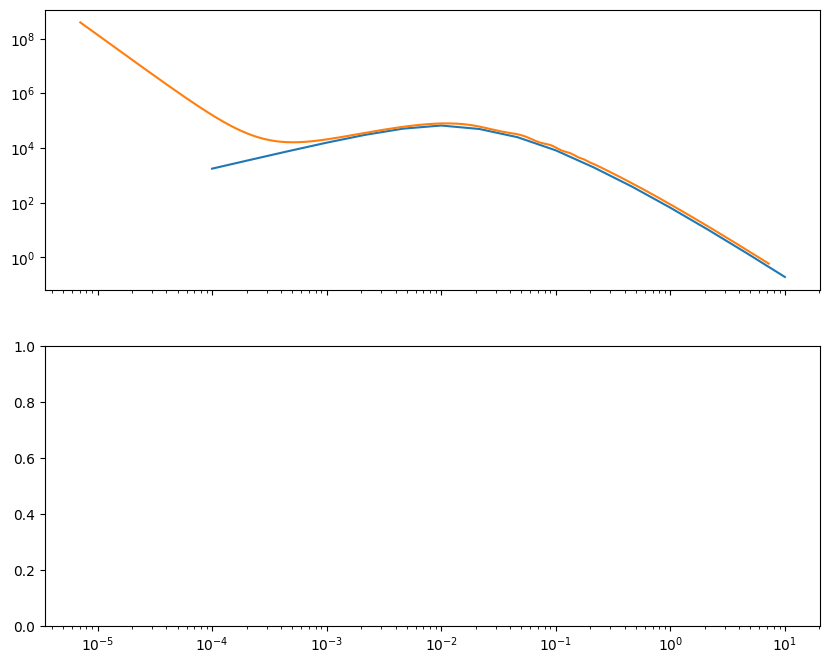

In [ ]:
print(kmodes.shape, k_CLASS.shape)

fig, ax = plt.subplots(2,figsize=(10, 8),sharex = True)

ax[0].loglog(kmodes,Pkc, label = 'DISCO-EB')
ax[0].loglog(k_CLASS,Pkc_CLASS, label = 'CLASS')


Pkc_EB_interp = interp1d(kmodes, Pkc)


ax[1].plot(k_CLASS[50:-10:1], (Pkc_EB_interp(k_CLASS[50:-10:1])-Pkc_CLASS[50:-10:1])/Pkc_CLASS[50:-10:1], label = 'Rel. Err')

ax[0].grid()
ax[0].legend()

ax[1].grid()
ax[1].legend()

ax[1].set_xlabel("$k$")
plt.show()

## $\Phi$ Bardeen Potential comparision

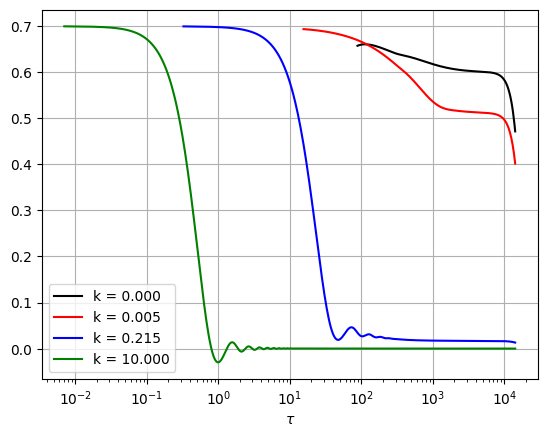

In [10]:
# print( pert.keys() )
# print( pert['scalar'][0].keys() )

phi = []
tau = []
a_c = []
for it, k in enumerate(kmodes):
    tau.append( pert['scalar'][it]['tau [Mpc]'] )
    a_c.append( pert['scalar'][it]['a'] )
    phi.append( pert['scalar'][it]['phi'] )
    # print('it = ', it, ' phi -> ', pert['scalar'][it]['phi'].shape, ' tau -> ', pert['scalar'][it]['tau [Mpc]'].shape, ' a-> ', pert['scalar'][it]['a'].shape)

plt.semilogx(tau[0],phi[0],'k', label = 'k = %.3f' % kmodes[0])
plt.semilogx(tau[5],phi[5],'r', label = 'k = %.3f' % kmodes[5])
plt.semilogx(tau[10],phi[10],'b', label = 'k = %.3f' % kmodes[10])
plt.semilogx(tau[15],phi[15],'g', label = 'k = %.3f' % kmodes[15])

plt.xlabel('$\\tau$')
plt.legend()
plt.grid()
plt.show()

1.0 1.0


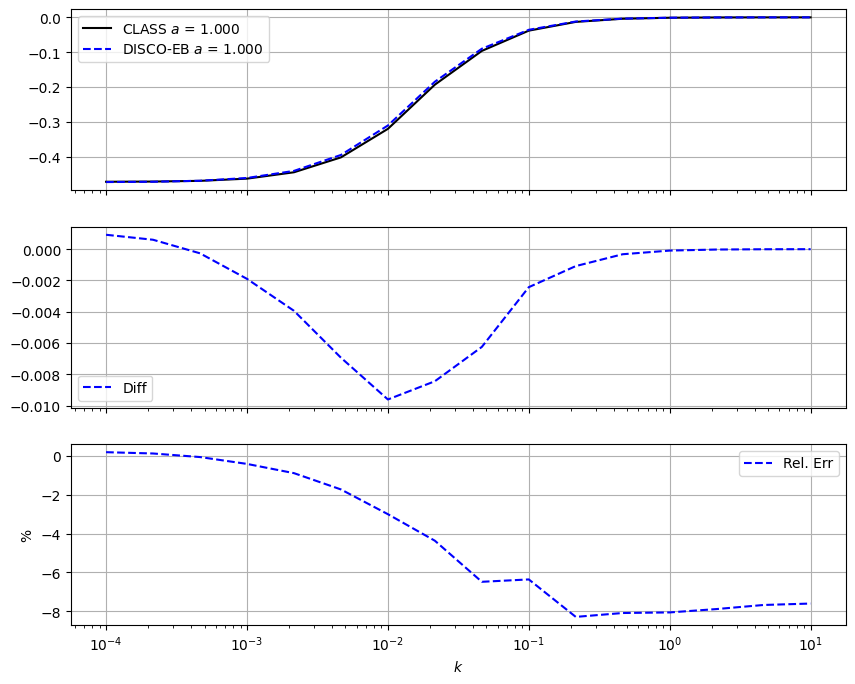

In [11]:
ind = -1
print(a_c[0][ind], aexp_out[ind])

phi_k = np.zeros_like(kmodes)
for it, k in enumerate(kmodes):
    phi_k[it] = phi[it][ind]

fig, ax = plt.subplots(3,figsize=(10, 8),sharex = True)

ax[0].semilogx(kmodes,-phi_k,'k', label = 'CLASS $a$ = %.3f' % a_c[0][ind])
ax[0].semilogx(kmodes,PhiB[:,ind],'b--', label = 'DISCO-EB $a$ = %.3f' % a_c[0][ind])

ax[1].semilogx(kmodes, (-phi_k-PhiB[:,ind]),'b--', label = 'Diff')

ax[2].semilogx(kmodes, (PhiB[:,ind]/(-phi_k) - 1)*100,'b--', label = 'Rel. Err')

ax[0].grid()
ax[0].legend()

ax[1].grid()
ax[1].legend()

ax[2].grid()
ax[2].legend()
ax[2].set_ylabel("$\\%$")

ax[2].set_xlabel("$k$")
plt.show()